In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

In [59]:
df = pd.read_csv('/content/drive/MyDrive/Class_ML/diabetes_prediction_dataset.csv')

df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [60]:
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1, 'Other': 2})
df['smoking_history'] = df['smoking_history'].replace(
    {'never': 0, 'No Info': np.nan,
     'current': 1, 'former': 1, 'ever': 1, 'not current': 1
    }
)
df.dropna(inplace=True)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,0.0,25.19,6.6,140,0
2,1,28.0,0,0,0.0,27.32,5.7,158,0
3,0,36.0,0,0,1.0,23.45,5.0,155,0
4,1,76.0,1,1,1.0,20.14,4.8,155,0
5,0,20.0,0,0,0.0,27.32,6.6,85,0


In [61]:
X = df.drop('diabetes', axis=1)
y = df['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [62]:
import lightgbm as lgb

model = lgb.LGBMClassifier(verbose=-1, random_seed=12)
model.fit(X_train, y_train)

LGBMClassifier(random_seed=12, verbose=-1)

In [63]:
from sklearn.metrics import classification_report

pred = model.predict(X_test)

print(classification_report(y_test, pred, digits=5))

              precision    recall  f1-score   support

           0    0.96321   0.99612   0.97939      5677
           1    0.95985   0.70889   0.81550       742

    accuracy                        0.96292      6419
   macro avg    0.96153   0.85251   0.89745      6419
weighted avg    0.96282   0.96292   0.96045      6419



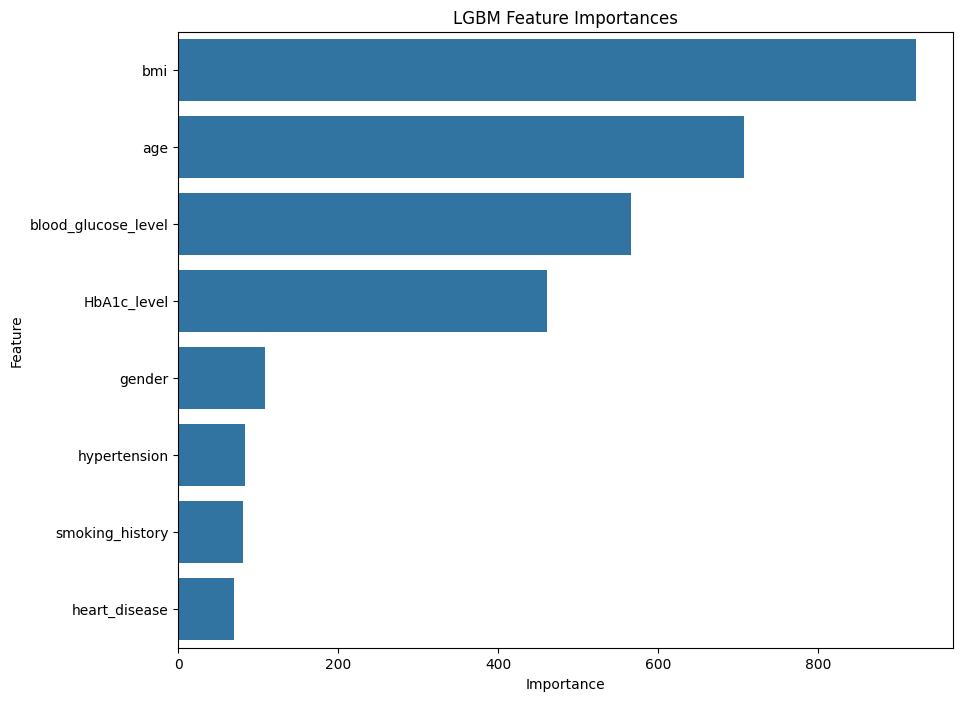

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# 獲取特徵重要性
feature_importances = model.feature_importances_
feature_names = X.columns

# 創建數據框
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# 按重要性排序
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 繪製圖形
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('LGBM Feature Importances')
plt.show()


## SHAP

In [65]:
!pip install -q shap

In [66]:
import shap

shap.initjs()

In [67]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

## 全局可解釋性(Global interpretability)
- Beeswarm
    - 橫軸（X 軸）：表示 SHAP 值的大小，即每個特徵對模型預測結果的影響。值越大，該特徵對模型輸出的影響越大。SHAP 值為正表示該特徵增加了預測的概率，為負則表示減少了預測的概率。
    
    - 縱軸（Y 軸）：表示模型的特徵。每個點代表該特徵在數據集中一個樣本的 SHAP 值。
    
    - 顏色：點的顏色表示特徵值的大小。顏色從藍色（低值）到紅色（高值）逐漸變化。例如，顏色為紅色的點表示該特徵在該樣本中的值較高。

- 如何解讀
1. 特徵影響大小：特徵的垂直位置越高，表示該特徵對模型輸出影響越大。例如，“HbA1c_level” 特徵影響最大。

2. 特徵值對影響方向的影響：顏色的分布可以幫助理解該特徵值的大小對模型預測的影響方向。例如，HbA1c_level的值越大（越紅），表示模型預測為患有DM的機率越大，。

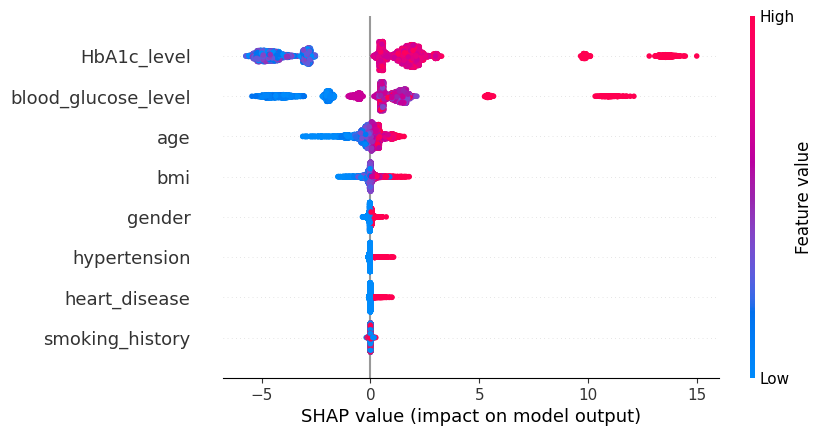

In [68]:
shap.plots.beeswarm(shap_values)

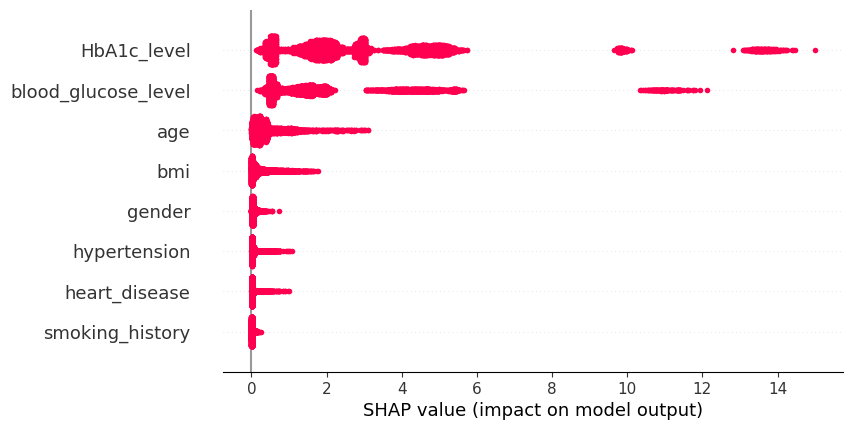

In [69]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

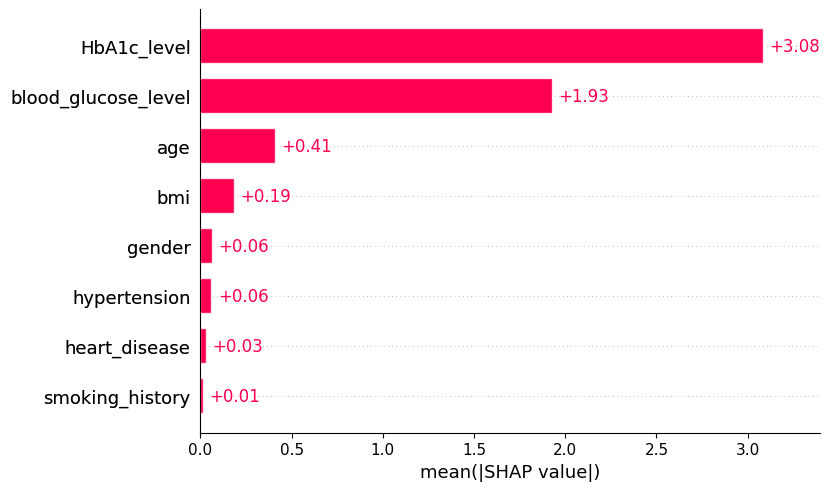

In [70]:
shap.plots.bar(shap_values,
            #    max_display=30
)

## 局部可解釋性(Local interpretability)

- 解釋測試集中的單一預測

### 瀑布圖

- 說明了每個特徵如何對單一預測做出貢獻
- 將預測推高的特徵顯示為紅色，將預測推低的特徵顯示為藍色。

此圖有效地顯示了所有這些特徵貢獻的組合如何產生最終的模型輸出。

這種詳細的細分有助於我們了解在該特定實例中驅動模型決策的具體因素，為模型的行為提供有價值的見解，並提高對其預測的信任度。

In [71]:
X_test.iloc[0]

gender                  1.00
age                    61.00
hypertension            0.00
heart_disease           0.00
smoking_history         1.00
bmi                    27.53
HbA1c_level             5.70
blood_glucose_level    80.00
Name: 46727, dtype: float64

In [72]:
y_test.iloc[0]

0

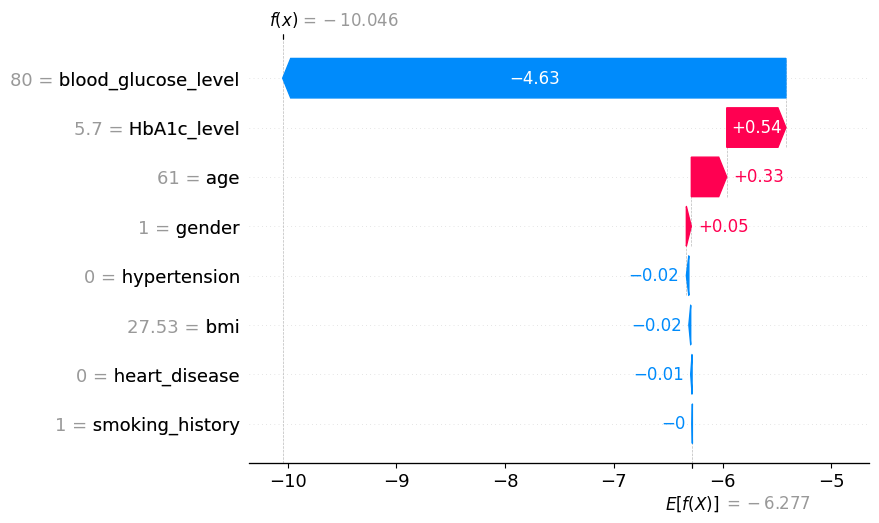

In [73]:
shap.plots.waterfall(shap_values[0])

### 模型的特徵重要性與 SHAP 值的不同排序可以由幾個因素引起：

1. 計算方法的不同：

    - model.feature_importances_：這通常是基於特徵在樹模型中出現的次數或其分裂的重要性來計算的。對於樹模型，如隨機森林或梯度提升機，這些重要性分數通常基於節點分裂時減少的損失函數

    - SHAP 值：這是基於博弈論中的 Shapley 值計算的。它計算每個特徵對預測的貢獻，並考慮所有可能的特徵組合。這是一種更具解釋性的方法，因為它考慮了特徵之間的相互影響

2. 考慮的範圍不同：

    - model.feature_importances_：只考慮單個特徵的影響，不考慮特徵之間的相互作用

    - SHAP 值：考慮了特徵之間的相互作用，提供了一個更全面的視圖

3. 計算細節：

    - model.feature_importances_：基於特徵分裂的統計數據

    - SHAP 值：基於對模型輸出的平均影響計算的貢獻值